In [1]:
import numpy as np
import netCDF4 as nc
import f90nml
import os
import xarray as xr
from salishsea_tools import bio_tools as bio
from salishsea_tools import viz_tools, visualisations
import matplotlib.pyplot as plt
import cmocean
import matplotlib as mpl


import pandas as pd
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

%matplotlib inline

In [2]:
def load_nml_bio(resDir,nmlname,bioRefName='namelist_lox_ref',bioCfgName='namelist_lox_cfg',namRefDir=None):
    """ extract parameter values from lox namelists for nampisbio
    :arg str resDir: directory containing namelists associated with run; usually results diri
    :arg str nmlname name of namelist to load: eg, 'nampisprod'
    :arg str bioRefName: name of bio reference namelist (optional)
    :arg str bioCfgName: name of bio config namelist (optional)
    :arg str namRefDir: dir to get ref namelist from if not in results dir (optional)
    """
    if namRefDir==None:
        namRefDir=resDir
    nmlRef=f90nml.read(os.path.join(namRefDir,bioRefName))
    nmlCfg=f90nml.read(os.path.join(resDir,bioCfgName))
    nml=nmlRef[nmlname]
    for key in nmlCfg[nmlname]:
        nml[key]=nmlCfg[nmlname][key]
    return nml

In [3]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [4]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'

In [5]:

file = 'biol'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [6]:
file2 = 'chem'

files2= []

for year in yearList:
    for month in range(1, 13):
        pattern = f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file2}_T_*{year}{month:02d}01_*{year}{month:02d}??.nc*'
        matches = glob.glob(pattern)

        # Only keep .nc or .nc.new files (not .nc.aside, etc.)
        valid = [f for f in matches if f.endswith('.nc') or f.endswith('.nc.new')]

        # Optional: make sure file exists
        valid = [f for f in valid if os.path.isfile(f)]

        if valid:
            files2.append(valid[0])  # or use `.extend(valid)` to keep all
        else:
            print(f" No valid .nc or .nc.new file for {year}-{month:02d}")
        


 No valid .nc or .nc.new file for 2022-12


In [7]:
file3 = 'grid'

for year in yearList:
    files3=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file3}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [8]:
## Gathering metadata but still not opening the files
dsfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['diatoms','flagellates','microzooplankton','mesozooplankton',\
                       'dissolved_organic_nitrogen','particulate_organic_nitrogen','biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [9]:
## Gathering metadata but still not opening the files
dsfiles2 = xr.open_mfdataset(
        files2,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['turbidity','dissolved_inorganic_carbon','total_alkalinity',\
                        'dissolved_oxygen','CO2_flux'],
        parallel=True,
        engine='netcdf4'
    )

In [10]:
## Gathering metadata but still not opening the files
dsfiles3 = xr.open_mfdataset(
        files3,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','vosaline','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [11]:
# load necessary files
#resDir='/results2/SalishSea/month-avg.201905/'
namDir='/results2/SalishSea/nowcast-green.202111/01jan15/'
nampisprod=bio.load_nml_bio(namDir,'nampisprod')
#fdia=nc.Dataset(os.path.join(resDir,'SalishSeaCast_1m_carp_T_20190601_20190630.nc'))
#fptc=nc.Dataset(os.path.join(resDir,'SalishSeaCast_1m_ptrc_T_20190601_20190630.nc'))
#m=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc')
#tmask=m.variables['tmask'][:,:,:,:]
#tmask=np.copy(m.variables['tmask'])
#navlon=np.copy(m.variables['nav_lon'])
#navlat=np.copy(m.variables['nav_lat'])
#m.close()
#fb=nc.Dataset('/data/eolson/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc')
#fm=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc')

## Bring in grid coordinates for Central Strait of Georgia slice/box

In [12]:
CentralSoG = [450, 500,250,300]

In [13]:
CSOGmask = np.broadcast_to(
    tmask[:, CentralSoG[0]:CentralSoG[1], CentralSoG[2]:CentralSoG[3]],
    (192, 40, 50, 50)
)

if CSOGmask.shape[0] < 192:
    # Create one NaN slice of shape (1, 40, 50, 50)
    nan_slice = np.full((1, 40, 50, 50), np.nan)

    # Concatenate to make it 192
    CSOGmask = np.concatenate([CSOGmask, nan_slice], axis=0)


In [14]:
np.shape(CSOGmask)

(192, 40, 50, 50)

In [15]:
tt=np.array(dsfiles.time)
mod_depth=np.array(dsfiles.depth)

In [16]:
CSOG_I=(dsfiles2.PAR[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_I = (np.array(CSOG_I))

if CSOG_I.shape[0] < 192:
    # Create one NaN slice of shape (1, 40, 50, 50)
    nan_slice = np.full((1, 40, 50, 50), np.nan)

    # Concatenate to make it 192
    CSOG_I = np.concatenate([CSOG_I, nan_slice], axis=0)

CSOG_I = np.ma.masked_where(CSOGmask==0,CSOG_I) ## masking where there is land


In [17]:
CSOG_NO=(dsfiles.nitrate[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_NO = (np.array(CSOG_NO))

CSOG_NO = np.ma.masked_where(CSOGmask==0,CSOG_NO) ## masking where there is land


In [18]:
CSOG_NH=(dsfiles.ammonium[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_NH = (np.array(CSOG_NH))

CSOG_NH = np.ma.masked_where(CSOGmask==0,CSOG_NH) ## masking where there is land


In [19]:
CSOG_Si=(dsfiles.silicon[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_Si = (np.array(CSOG_Si))

CSOG_Si = np.ma.masked_where(CSOGmask==0,CSOG_Si) ## masking where there is land


In [20]:
CSOG_T=(dsfiles3.votemper[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_T = (np.array(CSOG_T))

CSOG_T = np.ma.masked_where(CSOGmask==0,CSOG_T) ## masking where there is land

### Repeat for Juan de Fuca Region

In [21]:
JdF = [300,365, 50, 100]

In [22]:
JdFmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(192,40,65,50))

if JdFmask.shape[0] < 192:
    # Create one NaN slice of shape (1, 40, 50, 50)
    nan_slice = np.full((1, 40, 65, 50), np.nan)

    # Concatenate to make it 192
    JdFmask = np.concatenate([JdFmask, nan_slice], axis=0)


In [23]:
JdF_I=(dsfiles2.PAR[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_I = (np.array(JdF_I))

if JdF_I.shape[0] < 192:
    # Create one NaN slice of shape (1, 40, 65, 50)
    nan_slice = np.full((1, 40, 65, 50), np.nan)

    # Concatenate to make it 192
    JdF_I = np.concatenate([JdF_I, nan_slice], axis=0)

JdF_I = np.ma.masked_where(JdFmask==0,JdF_I) ## masking where there is land


In [24]:
JdF_NO=(dsfiles.nitrate[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_NO = (np.array(JdF_NO))

JdF_NO = np.ma.masked_where(JdFmask==0,JdF_NO) ## masking where there is land


In [25]:
JdF_NH=(dsfiles.ammonium[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_NH = (np.array(JdF_NH))

JdF_NH = np.ma.masked_where(JdFmask==0,JdF_NH) ## masking where there is land


In [26]:
JdF_Si=(dsfiles.silicon[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_Si = (np.array(JdF_Si))

JdF_Si = np.ma.masked_where(JdFmask==0,JdF_Si) ## masking where there is land


In [27]:
JdF_T=(dsfiles3.votemper[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_T = (np.array(JdF_T))

JdF_T = np.ma.masked_where(JdFmask==0,JdF_T) ## masking where there is land

#### Close files

In [28]:
dsfiles.close()

In [29]:
dsfiles2.close()

In [30]:
dsfiles3.close()

In [31]:
nml=bio.load_nml_bio(resDir='/ocean/eolson/MEOPAR/NEMO-3.6-code/NEMOGCM/CONFIG/SalishSeaCast/EXP00/',
                 nmlname='nampisprod',bioRefName='namelist_smelt_cfg_HC201905equiv',bioCfgName='namelist_smelt_cfg_HC201905equiv')

In [32]:
nampisprod

Namelist([('zz_rate_r_diat', 5.8e-05),
          ('zz_rate_r_myri', 0.0),
          ('zz_rate_r_flag', 1.8e-05),
          ('zz_rate_maxtemp_diat', 26.0),
          ('zz_rate_maxtemp_myri', 31.0),
          ('zz_rate_maxtemp_flag', 31.0),
          ('zz_rate_temprange_diat', 14.0),
          ('zz_rate_temprange_myri', 13.0),
          ('zz_rate_temprange_flag', 13.0),
          ('zz_pe_a_diat', 0.045),
          ('zz_pe_a_myri', 0.0),
          ('zz_pe_a_flag', 0.38),
          ('zz_pe_iopt_diat', 75.0),
          ('zz_pe_iopt_myri', 0.0),
          ('zz_pe_iopt_flag', 20.0),
          ('zz_rate_k_si_diat', 1.2),
          ('zz_rate_k_si_myri', 0.0),
          ('zz_rate_k_si_flag', 0.0),
          ('zz_rate_kapa_diat', 1.0),
          ('zz_rate_kapa_myri', 0.5),
          ('zz_rate_kapa_flag', 0.3),
          ('zz_rate_k_diat', 2.0),
          ('zz_rate_k_myri', 0.5),
          ('zz_rate_k_flag', 0.1),
          ('zz_rate_si_ratio_diat', 1.8),
          ('zz_rate_si_ratio_myri', 0.0),


In [33]:
def each_limiter(zz_I_par,zz_NO,zz_NH,zz_Si,tmask,
                 zz_pe_Iopt,zz_rate_K_Si,zz_rate_kapa,zz_rate_k):
    # Light
    zz_plank_growth_light = (1.0 - np.exp(-zz_I_par / (0.33 * zz_pe_Iopt)) ) * \
                           (np.exp(-zz_I_par / (30. * zz_pe_Iopt))) * 1.06
    zz_Uc =  zz_plank_growth_light
    ILim=zz_Uc
    # Si
    zz_Sc = np.where(np.logical_and(zz_Si>0.0,tmask>0),
                    zz_Si / (zz_rate_K_Si + zz_Si),0.0)
    SiLim=zz_Sc
    # Nitrate and Ammonium
    zz_Oup_cell = np.where(np.logical_and(zz_NO > 0.0,tmask>0),
                zz_NO * zz_rate_kapa / (zz_rate_k + zz_NO * zz_rate_kapa + zz_NH),0.0)
    zz_Hup_cell = np.where(np.logical_and(zz_NH > 0.0,tmask>0),
                zz_NH / (zz_rate_k + zz_NO * zz_rate_kapa + zz_NH),0.0)
    if (np.any(zz_Oup_cell < 0.)):
        raise ValueError('zz_Oup_cell<0')
    if (np.any(zz_Hup_cell < 0.)):
        raise ValueError('zz_Hup_cell<0')
    NLim=zz_Oup_cell+zz_Hup_cell
    # set flags
    limiter=-1*np.ones(zz_Si.shape)
    limiter=np.where(np.logical_and(ILim<=NLim,ILim<=SiLim),0,
                     np.where(NLim<=SiLim,2,np.where(SiLim<NLim,4,limiter)))
    limval=np.where(np.logical_and(ILim<=NLim,ILim<=SiLim),ILim,
                     np.where(NLim<=SiLim,NLim+2,np.where(SiLim<NLim,SiLim+4,limiter)))

    return ILim, NLim, SiLim, limiter,limval



In [34]:
def calc_p_limiters(I,NO,NH,Si,tmask,nampisprod):
    """Calculate limiting factor: I, Si, or N based on SMELT output

    :arg I: np.array slice of PAR from dia file
    :arg NO: " nitrate
    :arg NH: " ammonia
    :arg Si: " silicate
    :arg tmask: np.array containing appropriate tmask sliced to same size
    :arg nampisprod: namelist dict loaded using load_nml_bio with
                     argument nampisprod
    """
    ILimDiat, NLimDiat, SiLimDiat, limiterDiat, limvalDiat=each_limiter(I,NO,NH,Si,tmask,nampisprod['zz_pe_Iopt_diat'],
                                       nampisprod['zz_rate_k_Si_diat'],
                                        nampisprod['zz_rate_kapa_diat'],nampisprod['zz_rate_k_diat'])

    ILimMyri, NLimMyri, SiLimMyri, limiterMyri, limvalMyri=each_limiter(I,NO,NH,Si,tmask,nampisprod['zz_pe_Iopt_myri'],
                                        nampisprod['zz_rate_k_Si_myri'],
                                        nampisprod['zz_rate_kapa_myri'],nampisprod['zz_rate_k_myri'])

    ILimNano, NLimNano, SiLimNano, limiterNano, limvalNano=each_limiter(I,NO,NH,Si,tmask,nampisprod['zz_pe_Iopt_flag'],
                                        nampisprod['zz_rate_k_si_flag'],
                                        nampisprod['zz_rate_kapa_flag'],nampisprod['zz_rate_k_flag'])
    Diat={'ILim':ILimDiat,'NLim':NLimDiat,'SiLim':SiLimDiat,'limiter':limiterDiat,'limval':limvalDiat}
    Myri={'ILim':ILimMyri,'NLim':NLimMyri,'SiLim':SiLimMyri,'limiter':limiterMyri,'limval':limvalMyri}
    Nano={'ILim':ILimNano,'NLim':NLimNano,'SiLim':SiLimNano,'limiter':limiterNano,'limval':limvalNano}
    return Diat, Myri, Nano

In [35]:
#D,M,N = bio.calc_p_limiters(I,NO,NH,Si,tmask[0,:,:,:],nampisprod)
#D,N = calc_p_limiters(I,NO,NH,Si,newmask[:,0:20,:,:],nampisprod)
CSOG_D,CSOG_M,CSOG_N=calc_p_limiters(CSOG_I,CSOG_NO,CSOG_NH,CSOG_Si,CSOGmask[:,:,:,:],nampisprod)
JdF_D,JdF_M,JdF_N=calc_p_limiters(JdF_I,JdF_NO,JdF_NH,JdF_Si,JdFmask[:,:,:,:],nampisprod)

In [36]:
def phyto_Tdep_Factor(TT, zz_rate_maxtemp, zz_rate_temprange):
    
    return np.exp(0.07 * (TT - 20)) * np.minimum(np.maximum((zz_rate_maxtemp - TT), 0.0),zz_rate_temprange) / (zz_rate_temprange + 1e-10)

In [37]:
def calc_T_Factors(TT,nampisprod):
    Tdep_Diat=phyto_Tdep_Factor(TT,nampisprod['zz_rate_maxtemp_diat'],nampisprod['zz_rate_temprange_diat'])
    Tdep_Myri=phyto_Tdep_Factor(TT,nampisprod['zz_rate_maxtemp_myri'],nampisprod['zz_rate_temprange_myri'])
    Tdep_Nano=phyto_Tdep_Factor(TT,nampisprod['zz_rate_maxtemp_nano'],nampisprod['zz_rate_temprange_nano'])
    return Tdep_Diat, Tdep_Myri, Tdep_Nano

In [38]:
CSOG_Tdep_diat,__,CSOG_Tdep_flag=calc_T_Factors(CSOG_T,nml)
JdF_Tdep_diat,__,JdF_Tdep_flag=calc_T_Factors(JdF_T,nml)

In [39]:
np.shape(CSOG_Tdep_diat)

(192, 40, 50, 50)

In [40]:
np.shape(mod_depth),np.shape(CSOG_D['ILim'])

((40,), (192, 40, 50, 50))

In [41]:
CSOG_D['ILim']=np.mean(CSOG_D['ILim'], axis=(2,3)).T
CSOG_D['NLim']=np.mean(CSOG_D['NLim'], axis=(2,3)).T
CSOG_D['SiLim']=np.mean(CSOG_D['SiLim'], axis=(2,3)).T

In [42]:
JdF_D['ILim']=np.mean(JdF_D['ILim'], axis=(2,3)).T
JdF_D['NLim']=np.mean(JdF_D['NLim'], axis=(2,3)).T
JdF_D['SiLim']=np.mean(JdF_D['SiLim'], axis=(2,3)).T

In [43]:
CSOG_Tdep_diat=np.mean(CSOG_Tdep_diat, axis=(2,3)).T
JdF_Tdep_diat=np.mean(JdF_Tdep_diat, axis=(2,3)).T

In [44]:
np.shape(CSOG_D['ILim'])

(40, 192)

In [45]:
np.shape(JdF_D['ILim'])

(40, 192)

## Dataset for climatology

In [46]:
clim=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_biol_T_20070101_20231231.nc')
clim2=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_chem_T_20070101_20231231.nc')
clim3=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_grid_T_20070101_20231231.nc')

In [47]:
clim.variables.keys()

dict_keys(['nitrate', 'ammonium', 'silicon', 'diatoms', 'flagellates', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'mesozooplankton', 'depth', 'gridY', 'gridX', 'month'])

In [48]:
clim2.variables.keys()

dict_keys(['PAR', 'turbidity', 'dissolved_inorganic_carbon', 'total_alkalinity', 'dissolved_oxygen', 'CO2_flux', 'depth', 'gridY', 'gridX', 'month'])

In [49]:
CSOGclimmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(12,40,50,50)) ## mask for climatology files

In [50]:
CSOG_clim_I=np.ma.masked_where(CSOGclimmask==0,clim2['PAR'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

In [51]:
CSOG_clim_NO=np.ma.masked_where(CSOGclimmask==0,clim['nitrate'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

In [52]:
CSOG_clim_NH=np.ma.masked_where(CSOGclimmask==0,clim['ammonium'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

In [53]:
CSOG_clim_Si=np.ma.masked_where(CSOGclimmask==0,clim['silicon'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

In [54]:
CSOG_clim_T=np.ma.masked_where(CSOGclimmask==0,clim3['votemper'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

In [55]:
CSOG_clim_I_all=np.tile(CSOG_clim_I,(16,1,1,1))
CSOG_clim_NO_all=np.tile(CSOG_clim_NO,(16,1,1,1))
CSOG_clim_NH_all=np.tile(CSOG_clim_NH,(16,1,1,1))
CSOG_clim_Si_all=np.tile(CSOG_clim_Si,(16,1,1,1))
CSOG_clim_T_all=np.tile(CSOG_clim_T,(16,1,1,1))

In [56]:
CSOG_Tdep_diat_clim,__,CSOG_Tdep_flag_clim=calc_T_Factors(CSOG_clim_T_all,nml)

### Do the same for Juan de Fuca

In [57]:
JdFclimmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(12,40,65,50)) ## mask for climatology files

In [58]:
JdF_clim_I=np.ma.masked_where(JdFclimmask==0,clim2['PAR'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

In [59]:
JdF_clim_NO=np.ma.masked_where(JdFclimmask==0,clim['nitrate'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

In [60]:
JdF_clim_NH=np.ma.masked_where(JdFclimmask==0,clim['ammonium'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

In [61]:
JdF_clim_Si=np.ma.masked_where(JdFclimmask==0,clim['silicon'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

In [62]:
JdF_clim_T=np.ma.masked_where(JdFclimmask==0,clim3['votemper'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

In [63]:
JdF_clim_I_all=np.tile(JdF_clim_I,(16,1,1,1))
JdF_clim_NO_all=np.tile(JdF_clim_NO,(16,1,1,1))
JdF_clim_NH_all=np.tile(JdF_clim_NH,(16,1,1,1))
JdF_clim_Si_all=np.tile(JdF_clim_Si,(16,1,1,1))
JdF_clim_T_all=np.tile(JdF_clim_T,(16,1,1,1))

In [64]:
JdF_Tdep_diat_clim,__,JdF_Tdep_flag_clim=calc_T_Factors(JdF_clim_T_all,nml)

In [65]:
np.shape(JdF_Tdep_diat_clim)

(192, 40, 65, 50)

### Calculate the limiters for the climatology

In [66]:
def calc_p_limiters_clim(clim_I_all,clim_NO_all,clim_NH_all,clim_Si_all,tmask,nampisprod):
    """Calculate limiting factor: I, Si, or N based on SMELT output

    :arg I: np.array slice of PAR from dia file
    :arg NO: " nitrate
    :arg NH: " ammonia
    :arg Si: " silicate
    :arg tmask: np.array containing appropriate tmask sliced to same size
    :arg nampisprod: namelist dict loaded using load_nml_bio with
                     argument nampisprod
    """
    ILimDiat, NLimDiat, SiLimDiat, limiterDiat, limvalDiat=each_limiter(clim_I_all,clim_NO_all,clim_NH_all,clim_Si_all,tmask,nampisprod['zz_pe_Iopt_diat'],
                                       nampisprod['zz_rate_k_Si_diat'],
                                        nampisprod['zz_rate_kapa_diat'],nampisprod['zz_rate_k_diat'])

    ILimMyri, NLimMyri, SiLimMyri, limiterMyri, limvalMyri=each_limiter(clim_I_all,clim_NO_all,clim_NH_all,clim_Si_all,tmask,nampisprod['zz_pe_Iopt_myri'],
                                        nampisprod['zz_rate_k_Si_myri'],
                                        nampisprod['zz_rate_kapa_myri'],nampisprod['zz_rate_k_myri'])

    ILimNano, NLimNano, SiLimNano, limiterNano, limvalNano=each_limiter(clim_I_all,clim_NO_all,clim_NH_all,clim_Si_all,tmask,nampisprod['zz_pe_Iopt_flag'],
                                        nampisprod['zz_rate_k_si_flag'],
                                        nampisprod['zz_rate_kapa_flag'],nampisprod['zz_rate_k_flag'])
    Diat={'ILim':ILimDiat,'NLim':NLimDiat,'SiLim':SiLimDiat,'limiter':limiterDiat,'limval':limvalDiat}
    Myri={'ILim':ILimMyri,'NLim':NLimMyri,'SiLim':SiLimMyri,'limiter':limiterMyri,'limval':limvalMyri}
    Nano={'ILim':ILimNano,'NLim':NLimNano,'SiLim':SiLimNano,'limiter':limiterNano,'limval':limvalNano}
    return Diat, Myri, Nano

In [67]:
#D,M,N = bio.calc_p_limiters(I,NO,NH,Si,tmask[0,:,:,:],nampisprod)
#D,N = calc_p_limiters(I,NO,NH,Si,newmask[:,0:20,:,:],nampisprod)
CSOG_D_clim,CSOG_M_clim,CSOG_N_clim=calc_p_limiters_clim(CSOG_clim_I_all,CSOG_clim_NO_all,CSOG_clim_NH_all,CSOG_clim_Si_all,CSOGmask[:,:,:,:],nampisprod)

In [68]:
np.shape(mod_depth),np.shape(CSOG_D_clim['ILim'])

((40,), (192, 40, 50, 50))

In [69]:
#D,M,N = bio.calc_p_limiters(I,NO,NH,Si,tmask[0,:,:,:],nampisprod)
#D,N = calc_p_limiters(I,NO,NH,Si,newmask[:,0:20,:,:],nampisprod)
JdF_D_clim,JdF_M_clim,JdF_N_clim=calc_p_limiters_clim(JdF_clim_I_all,JdF_clim_NO_all,JdF_clim_NH_all,JdF_clim_Si_all,JdFmask[:,:,:,:],nampisprod)

In [70]:
CSOG_D_clim['ILim']=np.mean(CSOG_D_clim['ILim'], axis=(2,3)).T
CSOG_D_clim['NLim']=np.mean(CSOG_D_clim['NLim'], axis=(2,3)).T
CSOG_D_clim['SiLim']=np.mean(CSOG_D_clim['SiLim'], axis=(2,3)).T

In [71]:
JdF_D_clim['ILim']=np.mean(JdF_D_clim['ILim'], axis=(2,3)).T
JdF_D_clim['NLim']=np.mean(JdF_D_clim['NLim'], axis=(2,3)).T
JdF_D_clim['SiLim']=np.mean(JdF_D_clim['SiLim'], axis=(2,3)).T

In [72]:
CSOG_T_dep_clim=np.mean(CSOG_Tdep_diat_clim, axis=(2,3)).T
JdF_T_dep_clim=np.mean(JdF_Tdep_diat_clim, axis=(2,3)).T

In [73]:
## Designate date_range for Hovmoller plots

start= dt.datetime(2007,1,1)
end=dt.datetime(2022,12,31)

In [74]:
date_range=(start,end)

### Plotting for Central Strait of Georgia

In [75]:
print((CSOG_Tdep_diat-CSOG_T_dep_clim).min())
print((CSOG_Tdep_diat-CSOG_T_dep_clim).max())

-0.10168075102474428
0.066919650411778


/ocean/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/Keegan_eval_tools.py:816: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


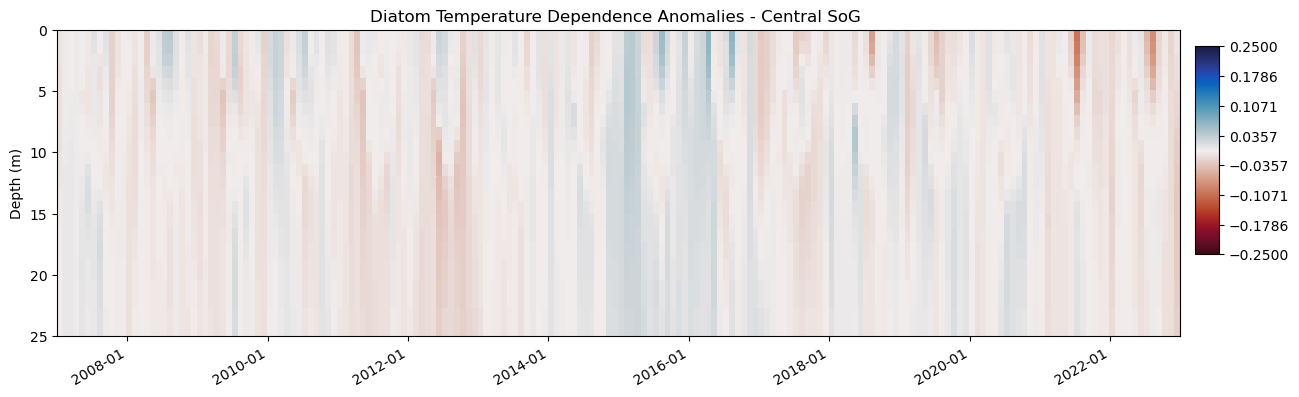

In [76]:
ax=ket.hovmoeller((CSOG_Tdep_diat-CSOG_T_dep_clim), mod_depth, tt,(0,25),date_range, title='Diatom Temperature Dependence Anomalies - Central SoG ',
               var_title='',vmax=-.25,vmin=.25,cmap=cmo.cm.balance_r)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


In [77]:
print((CSOG_D['ILim']-CSOG_D_clim['ILim']).min())
print((CSOG_D['ILim']-CSOG_D_clim['ILim']).max())

-0.12397439676399757
0.10632781932430535


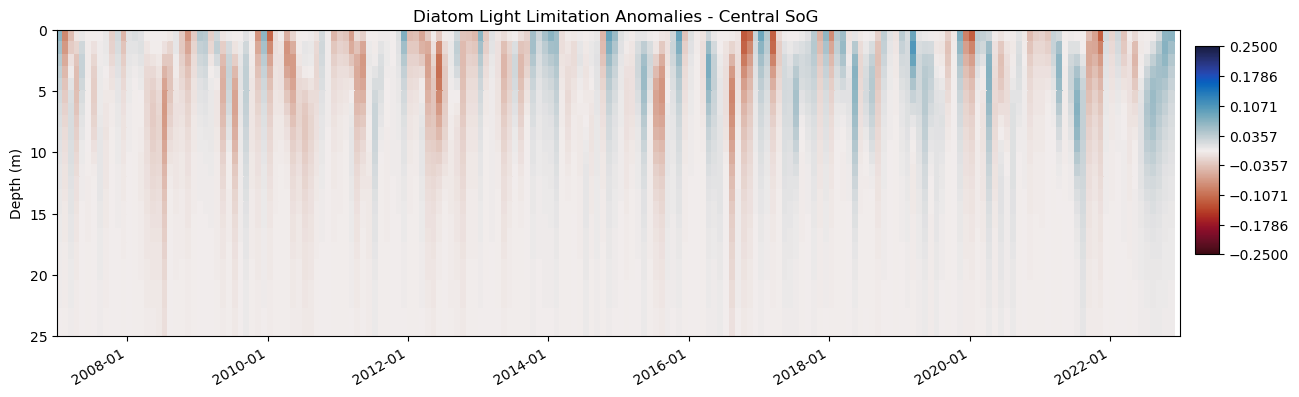

In [78]:
ax=ket.hovmoeller((CSOG_D['ILim']-CSOG_D_clim['ILim']), mod_depth, tt,(0,25),date_range, title='Diatom Light Limitation Anomalies - Central SoG ',
               var_title='',vmax=-.25,vmin=.25,cmap=cmo.cm.balance_r)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


In [79]:
print((CSOG_D['NLim']-CSOG_D_clim['NLim']).min())
print((CSOG_D['NLim']-CSOG_D_clim['NLim']).max())

-0.2540309
2.661741


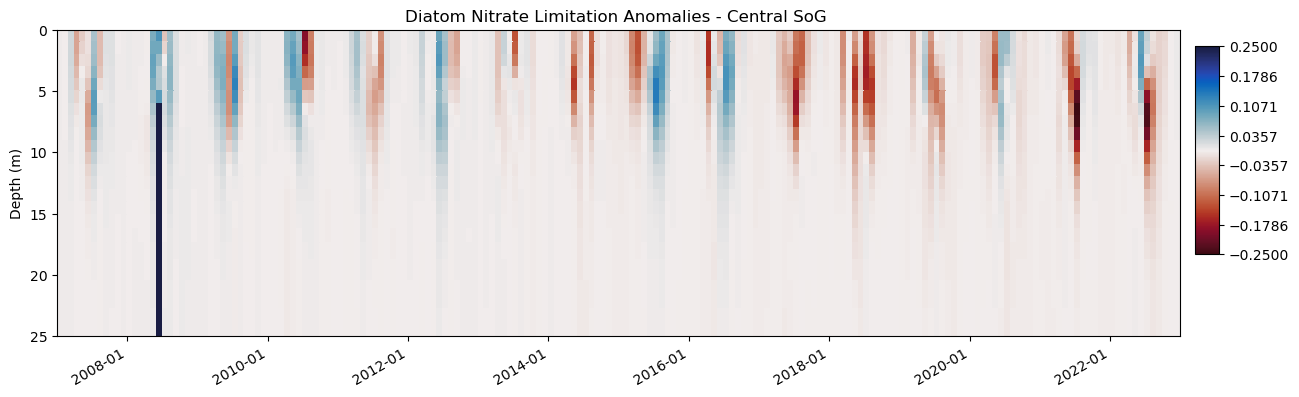

In [80]:
ax=ket.hovmoeller((CSOG_D['NLim']-CSOG_D_clim['NLim']), mod_depth, tt,(0,25),date_range, title='Diatom Nitrate Limitation Anomalies - Central SoG ',
               var_title='',vmax=-.25,vmin=.25,cmap=cmo.cm.balance_r)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


### Plotting for Juan de Fuca

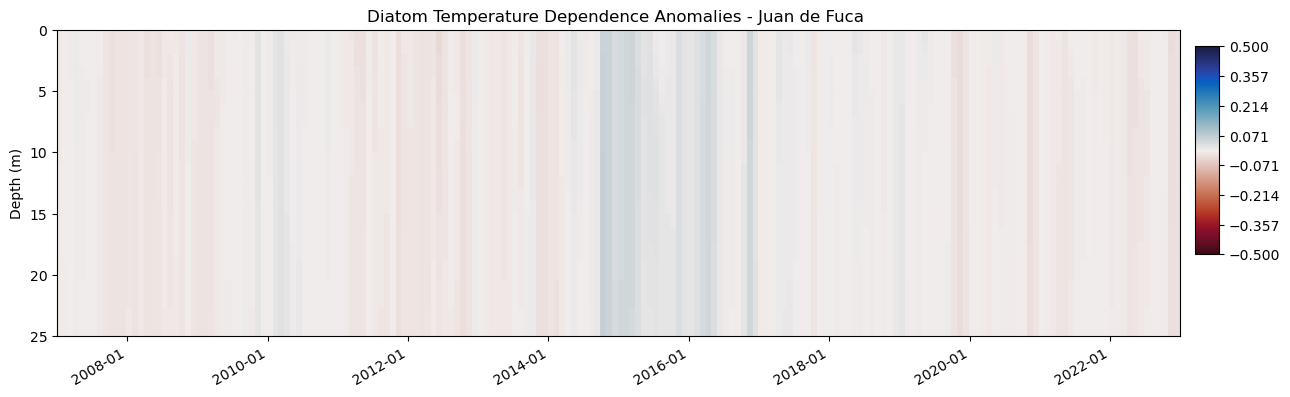

In [81]:
ax=ket.hovmoeller((JdF_Tdep_diat-JdF_T_dep_clim), mod_depth, tt,(0,25),date_range, title='Diatom Temperature Dependence Anomalies - Juan de Fuca ',
               var_title='',vmax=-.5,vmin=.5,cmap=cmo.cm.balance_r)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


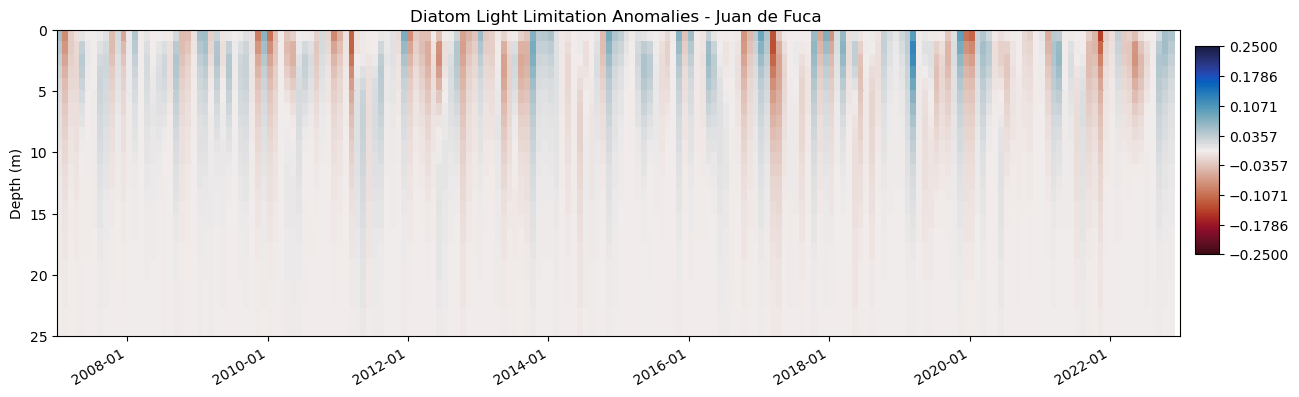

In [82]:
ax=ket.hovmoeller((JdF_D['ILim']-JdF_D_clim['ILim']), mod_depth, tt,(0,25),date_range, title='Diatom Light Limitation Anomalies - Juan de Fuca ',
               var_title='',vmax=-.25,vmin=.25,cmap=cmo.cm.balance_r)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


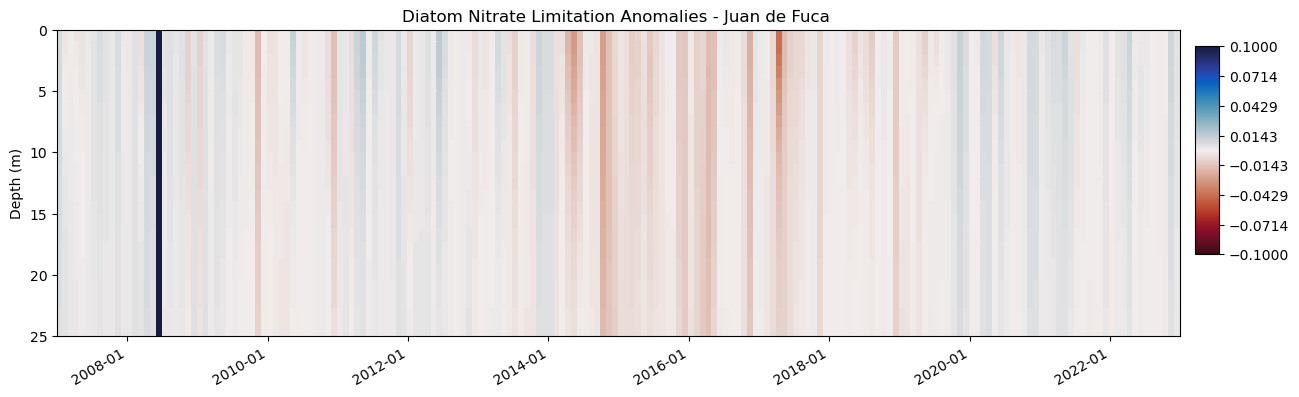

In [83]:
ax=ket.hovmoeller((JdF_D['NLim']-JdF_D_clim['NLim']), mod_depth, tt,(0,25),date_range, title='Diatom Nitrate Limitation Anomalies - Juan de Fuca ',
               var_title='',vmax=-.1,vmin=.1,cmap=cmo.cm.balance_r)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


### Calculate 0-50 m surface means for each region

In [84]:
CSOG_DNLim_surf=np.mean(CSOG_D['NLim'][0:23],axis=0)

In [85]:
CSOG_DILim_surf=np.mean(CSOG_D['ILim'][0:23],axis=0)

In [86]:
CSOG_DSiLim_surf=np.mean(CSOG_D['SiLim'][0:23],axis=0)

In [87]:
CSOG_Tdep_diatsurf=np.mean(CSOG_Tdep_diat[0:23],axis=0)

In [88]:
JdF_DNLim_surf=np.mean(JdF_D['NLim'][0:23],axis=0)

In [89]:
JdF_DILim_surf=np.mean(JdF_D['ILim'][0:23],axis=0)

In [90]:
JdF_DSiLim_surf=np.mean(JdF_D['SiLim'][0:23],axis=0)

In [91]:
JdF_Tdep_diatsurf=np.mean(JdF_Tdep_diat[0:23],axis=0)

### Now calculate 0-50m Anomalies

In [92]:
CSOG_DNLim_anom=np.mean(CSOG_D['NLim'][0:23]-CSOG_D_clim['NLim'][0:23],axis=0)

In [93]:
CSOG_DILim_anom=np.mean(CSOG_D['ILim'][0:23]-CSOG_D_clim['ILim'][0:23],axis=0)

In [94]:
CSOG_DSiLim_anom=np.mean(CSOG_D['SiLim'][0:23]-CSOG_D_clim['SiLim'][0:23],axis=0)

In [95]:
CSOG_Tdep_diatanom=np.mean(CSOG_Tdep_diat[0:23]-CSOG_T_dep_clim[0:23],axis=0)

In [96]:
CSOG_DNLim_anom[17] ## Need to delete this value for Nitrate and Silicon due to missing data

1.4530343

In [97]:
JdF_DNLim_anom=np.mean(JdF_D['NLim'][0:23]-JdF_D_clim['NLim'][0:23],axis=0)

In [98]:
JdF_DILim_anom=np.mean(JdF_D['ILim'][0:23]-JdF_D_clim['ILim'][0:23],axis=0)

In [99]:
JdF_DSiLim_anom=np.mean(JdF_D['SiLim'][0:23]-JdF_D_clim['SiLim'][0:23],axis=0)

In [100]:
JdF_Tdep_diatanom=np.mean(JdF_Tdep_diat[0:23]-JdF_T_dep_clim[0:23],axis=0)

In [101]:
JdF_DNLim_anom[17] ## Need to delete this value for Nitrate and Silicon due to missing data

1.0931451

Text(0.04, 0.5, 'Limitations on Diatom Growth')

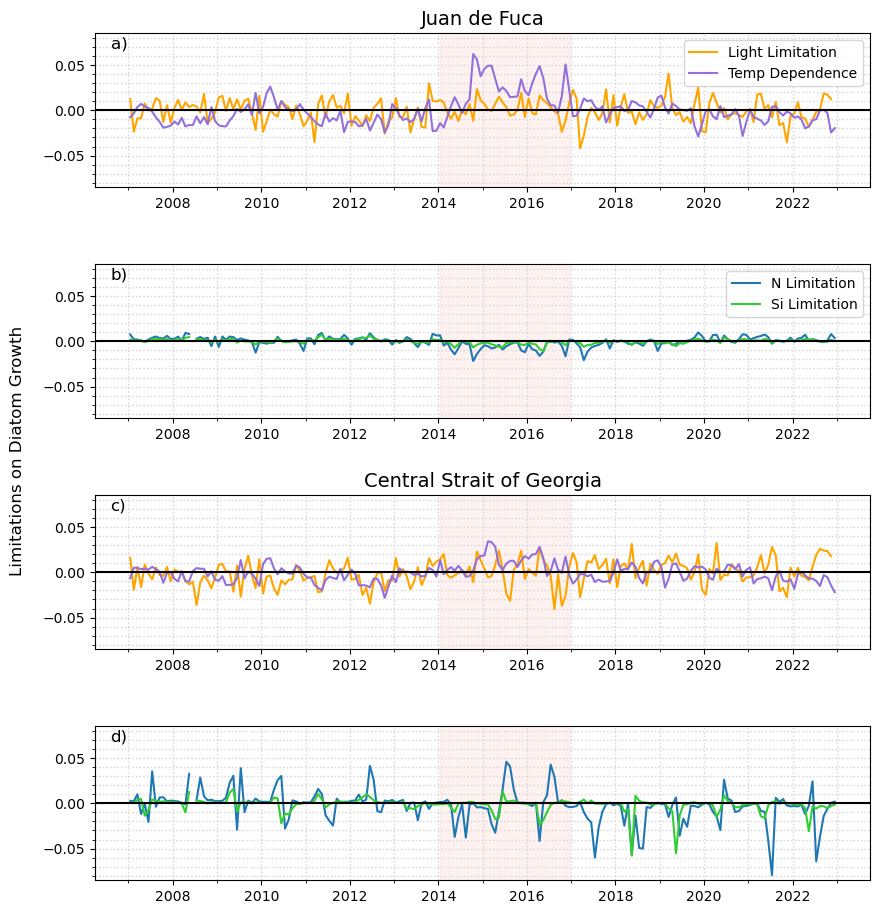

In [107]:
fig,ax=plt.subplots(4,1,figsize=(10,11))

CSOG_DNLim_anom[17] = np.nan
CSOG_DSiLim_anom[17] = np.nan
JdF_DNLim_anom[17] = np.nan
JdF_DSiLim_anom[17] = np.nan

hloc = YearLocator(1)
a = tt[84]
b = tt[119]

ax[0].plot(tt,JdF_DILim_anom,color='orange',label='Light Limitation')
ax[0].plot(tt,JdF_Tdep_diatanom,color='mediumpurple',label='Temp Dependence')
ax[0].set_ylim(-0.085,.085)
ax[0].legend(loc=1) #bbox_to_anchor=(1.05, 1), loc='upper left'
ax[0].axhline(y=0,color='k',linestyle='-')
ax[0].set_title('Juan de Fuca',fontsize=14)
ax[0].text(0.02, 0.9, 'a)', transform=ax[0].transAxes, fontsize=12)
ax[0].minorticks_on()
ax[0].grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
ax[0].grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
ax[0].xaxis.set_minor_locator(hloc)  
ax[0].fill_between([a, b], -10, 10, color='salmon', alpha=0.1)

ax[1].plot(tt,JdF_DNLim_anom,label='N Limitation')
ax[1].plot(tt,JdF_DSiLim_anom,color='limegreen',label='Si Limitation')
ax[1].set_ylim(-0.085,.085)
ax[1].legend(loc=1) #bbox_to_anchor=(1.05, 1), loc='upper left'
ax[1].axhline(y=0,color='k',linestyle='-')
ax[1].text(0.02, 0.9, 'b)', transform=ax[1].transAxes, fontsize=12)
ax[1].minorticks_on()
ax[1].grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
ax[1].grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
ax[1].xaxis.set_minor_locator(hloc)  
ax[1].fill_between([a, b], -10, 10, color='salmon', alpha=0.1)

ax[2].plot(tt,CSOG_DILim_anom,color='orange',label='')
ax[2].plot(tt,CSOG_Tdep_diatanom,color='mediumpurple',linestyle='-',label='')
ax[2].set_ylim(-0.085,.085)
#ax[2].legend()
ax[2].axhline(y=0,color='k',linestyle='-')
ax[2].set_title('Central Strait of Georgia',fontsize=14)
ax[2].text(0.02, 0.9, 'c)', transform=ax[2].transAxes, fontsize=12)
ax[2].minorticks_on()
ax[2].grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
ax[2].grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
ax[2].xaxis.set_minor_locator(hloc)
ax[2].fill_between([a, b], -10, 10, color='salmon', alpha=0.1)


ax[3].plot(tt,CSOG_DNLim_anom,linestyle='-',label='')
ax[3].plot(tt,CSOG_DSiLim_anom,color='limegreen',linestyle='-',label='')
ax[3].set_ylim(-0.085,.085)
#ax[3].legend()
ax[3].axhline(y=0,color='k',linestyle='-')
ax[3].text(0.02, 0.9, 'd)', transform=ax[3].transAxes, fontsize=12)
ax[3].minorticks_on()
ax[3].grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
ax[3].grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
ax[3].xaxis.set_minor_locator(hloc)
ax[3].fill_between([a, b], -10, 10, color='salmon', alpha=0.1)


# Adjust vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)  # Increase spacing, play with the value until it suits your need


# Shared y-axis label
fig.text(0.04, 0.5, 'Limitations on Diatom Growth', va='center', rotation='vertical', fontsize=12)

#plt.savefig('Figure9_DiatomLimitationPlots.png', bbox_inches='tight',dpi=1000,transparent=False)